# **Rocket**

This benchmarking workbook evaluating the Rocket model has been adapted from a [Github](https://github.com/sktime/sktime/blob/main/examples/transformation/rocket.ipynb) demonstration for the *sktime* package. The Rocket transformation is followed up with a Ridge Classifier, per the original Rocket paper.

In [1]:
pip install sktime==0.31.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.9/28.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 6.3 MB/s eta 0:00:00


In [2]:
#You MUST run this command before reading in any data from Google Drive
from google.colab import files
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Thesis/benchmarks')

Mounted at /content/drive


In [12]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

np.random.seed(123)

%run ../sys_configs.ipynb
%run ../plots.ipynb

ROCKET [1] transforms time series using random convolutional kernels (random length, weights, bias, dilation, and padding). ROCKET computes two features from the resulting feature maps: the max, and the proportion of positive values (or ppv). The transformed features are used to train a linear classifier.

In [4]:
with open('../data/train.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f).astype(np.int64)
sz, dim = x_train.shape[1:]

with open('../data/val.npy', 'rb') as f:
    x_val = np.load(f)
    y_val = np.load(f).astype(np.int64)

with open('../data/test.npy', 'rb') as f:
    x_test = np.load(f)
    y_test = np.load(f).astype(np.int64)

classes = np.unique(y_train)

N_train = len(y_train)
N_val = len(y_val)
N_test = len(y_test)

In [5]:
x_train = x_train.transpose((0, 2, 1))
x_val = x_val.transpose((0, 2, 1))
x_test = x_test.transpose((0, 2, 1))

***

## **Apply Rocket**

In [6]:
rocket = Rocket(num_kernels=10000, normalise = False) # Per the original paper. The data is already normalised.
rocket.fit(x_train)
X_train_transform = rocket.transform(x_train)

In [9]:
# Load and Transform the Test Data
X_val_transform = rocket.transform(x_val)
X_test_transform = rocket.transform(x_test)

In [13]:
# Need to scale the inputs, otherwise the Rocket classifier may only be able to learn inputs for the Max features (which have orders of magnitude smaller weights)
scaler = StandardScaler()
scaled_data = scaler.fit(X_train_transform)

In [14]:
X_train_transform_scaled = scaled_data.transform(X_train_transform)
X_val_transform_scaled = scaled_data.transform(X_val_transform)
X_test_transform_scaled = scaled_data.transform(X_test_transform)

In [15]:
# Fit the classifier
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), store_cv_values = True)
classifier.fit(X_train_transform_scaled, y_train)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  store_cv_values=True)

In [17]:
print(f"The best choice of alpha was {classifier.alpha_}")

The best choice of alpha was 46.41588833612773


In [18]:
predictions_val = classifier.predict(X_val_transform_scaled)
predictions_test = classifier.predict(X_test_transform_scaled)

In [19]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_val), sum(np.equal(predictions_val, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_test), sum(np.equal(predictions_test, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 1135
Test Data - Total predictions made: 1051. Number of correct predictions: 851


### **Visualise predictions for test set**

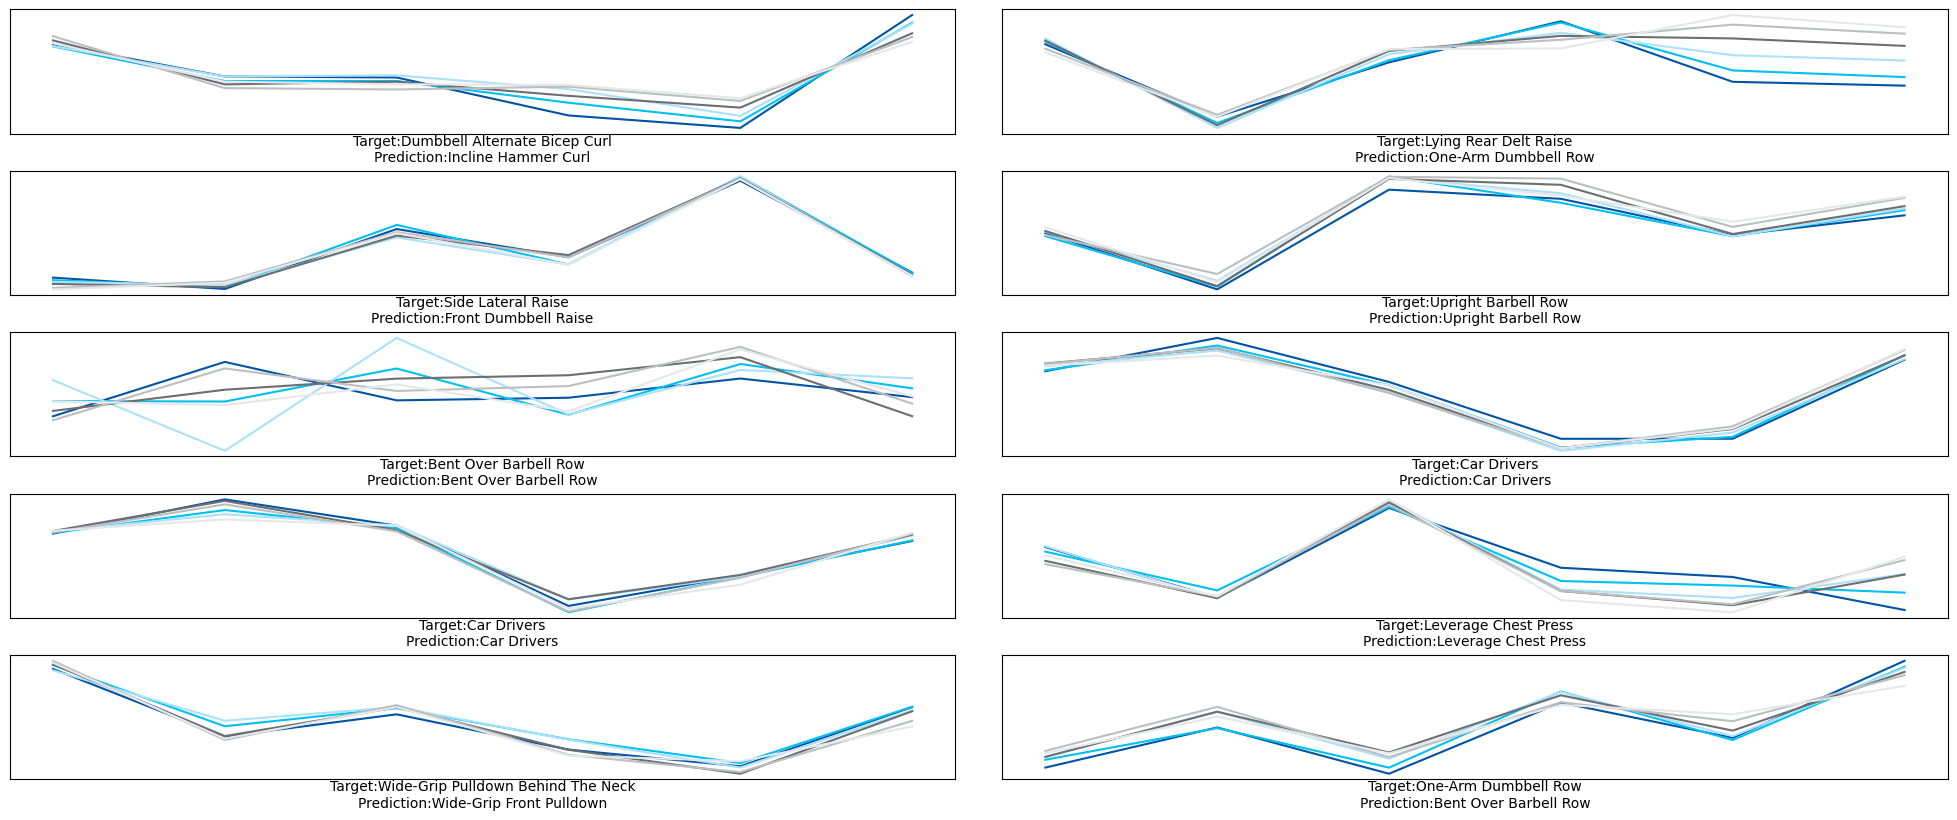

In [20]:
plot_samples(data = x_test, labels = y_test, predictions = predictions_test)

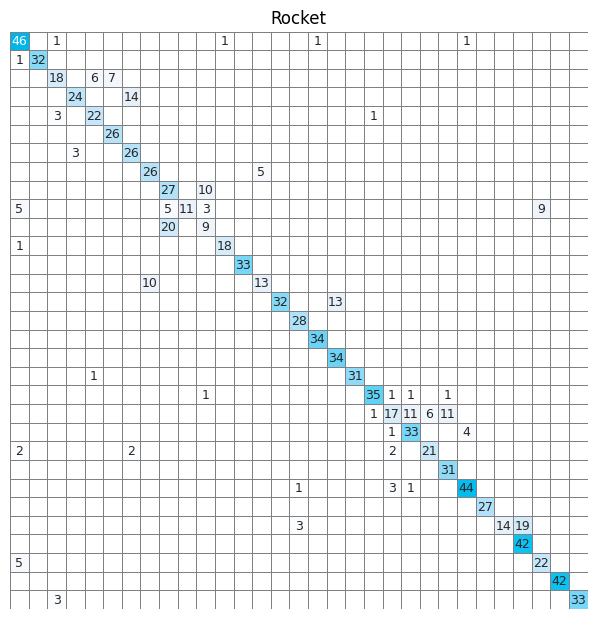

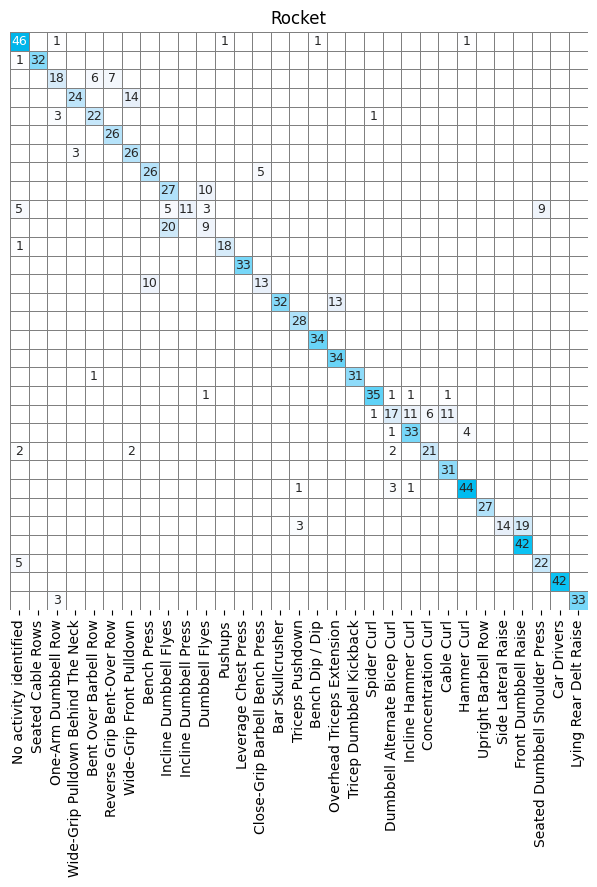

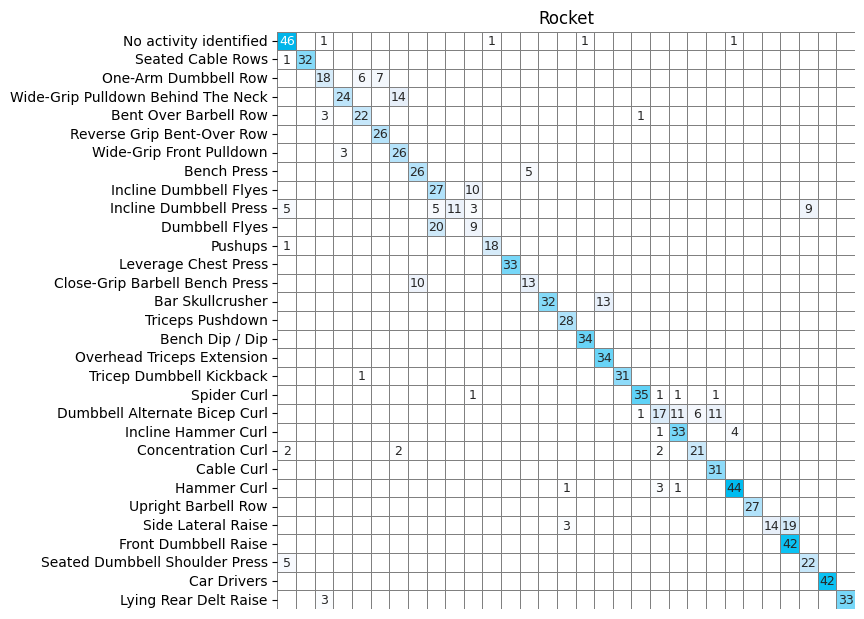

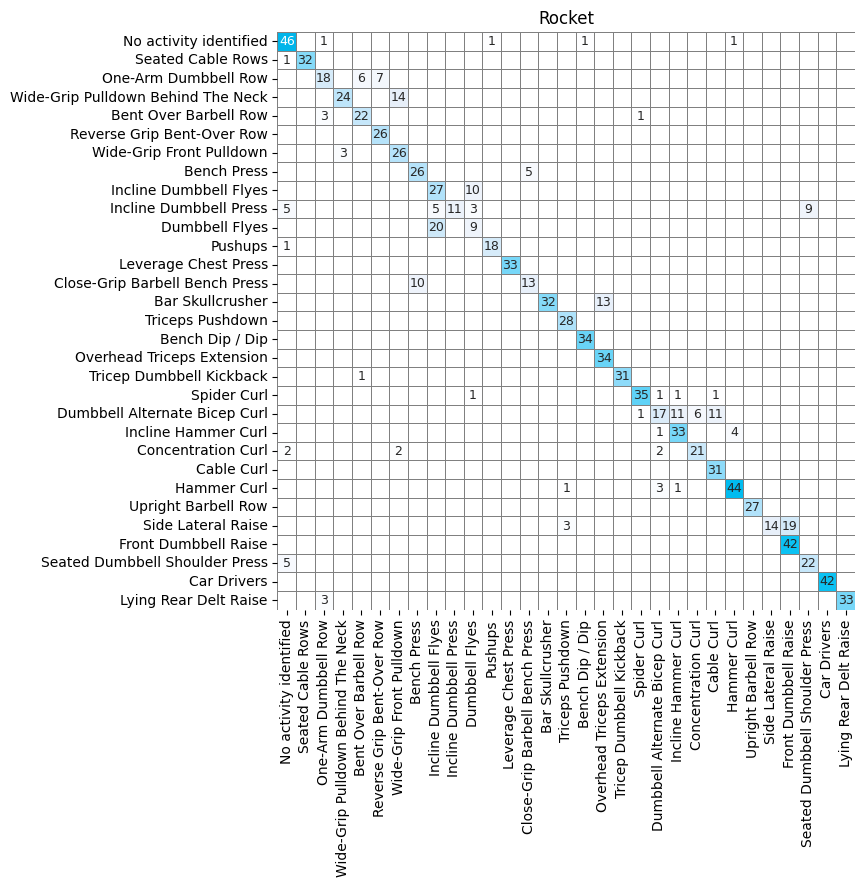

In [21]:
cm = confusion_matrix(y_test, predictions_test, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm, x_ticks = False, y_ticks = False, save = True, title = "Rocket")
plot_confusion_matrix(cm, x_ticks = True, y_ticks = False, save = True, title = "Rocket")
plot_confusion_matrix(cm, x_ticks = False, y_ticks = True, save = True, title = "Rocket")
plot_confusion_matrix(cm, x_ticks = True, y_ticks = True, save = True, title = "Rocket")

This has almost identical performance to the CNN-BiResGRU architecture tested on the MyoGym data.

### **References**

[1] Dempster A, Petitjean F, Webb GI (2019) ROCKET: Exceptionally fast and accurate time series classification using random convolutional kernels. [arXiv:1910.13051](https://arxiv.org/abs/1910.13051)